###### Init env

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [3]:
# read data and skip 'date' colume
df = pd.read_csv('./dataset/netflix-prize-data/combined_data_1.txt', 
                 header = None, names = ['user', 'rating'], 
                 usecols = [0,1])

# process data type
df['rating']=df['rating'].astype(float)


In [4]:
# find empty rows for slice movies 
# dataset using movie id as user name for splite rating of each movies
movies_interval = df[df['rating'].isna()]['user'].reset_index()
movies_interval['index'] = movies_interval['index'].astype(int)

In [5]:
#* this is too slow *#
# df.insert(0,'movie',0)
# last = None
# for i,r in movies_interval.iterrows():
#     if last != None:
#         df.at[last:r['index'],'movie'] = r['user']
#     last = r['index']

# create list accroding to movie interval by np
movie_id = 1
movie_np = []
last = None
for i,r in movies_interval.iterrows():
    if last != None: 
        temp = np.full((1,r['index']-last-1), movie_id)
        movie_np = np.append(movie_np, temp)
        movie_id +=1
    last = r['index']

In [6]:
# add last movie
temp = np.full((1,len(df)-last-1), movie_id)
movie_np = np.append(movie_np, temp)

In [7]:
# removie movie slice row, and combine movie colume
df = df[pd.notnull(df['rating'])]
df['movie'] = movie_np.astype(int)

   rating    count
0     1.0  1118186
1     2.0  2439073
2     3.0  6904181
3     4.0  8085741
4     5.0  5506583


<BarContainer object of 5 artists>

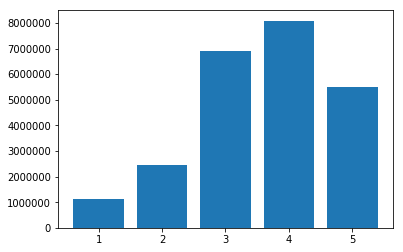

In [8]:
# distribution of rating
rating_distr = df.groupby('rating')['rating'].agg(['count']).reset_index()
print(rating_distr)
plt.bar(rating_distr["rating"],rating_distr["count"])

{'whiskers': [<matplotlib.lines.Line2D at 0x1300446a0>,
 'caps': [<matplotlib.lines.Line2D at 0x130046080>,
 'boxes': [<matplotlib.lines.Line2D at 0x130044550>],
 'medians': [<matplotlib.lines.Line2D at 0x130046940>],
 'fliers': [<matplotlib.lines.Line2D at 0x130046da0>],
 'means': []}

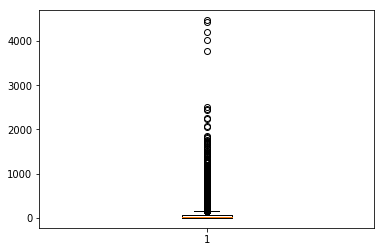

In [42]:
# the rating activity
user_activity = df.groupby('user')['user'].agg(['count']).reset_index()
plt.boxplot(user_activity['count'].astype(int))

         binned   count
0        (0, 1]   15225
1       (1, 10]  124902
2     (10, 100]  260361
3   (100, 1000]   70185
4  (1000, 2000]      73
5  (2000, 3000]       7
470758


<BarContainer object of 6 artists>

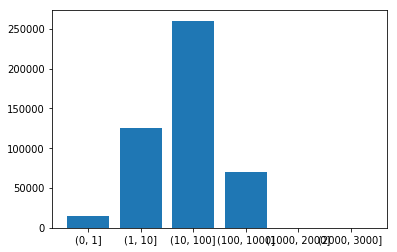

In [43]:
# binning user-rating
bins = [0,1,10,100,1000,2000,3000]
user_activity['binned'] = pd.cut(user_activity['count'], bins)
user_activity_bin = user_activity.groupby('binned')['binned'].agg(['count']).reset_index()
print(user_activity_bin)
print(len(user_activity))
plt.bar(user_activity_bin['binned'].astype(str),user_activity_bin['count'])

In [44]:
# user_activity[user_activity['count']<10]

(array([ 256., 2501., 1251.,  377.,   75.,   32.]),
 array([     0,    100,   1000,  10000,  50000, 100000, 150000]),
 <a list of 6 Patch objects>)

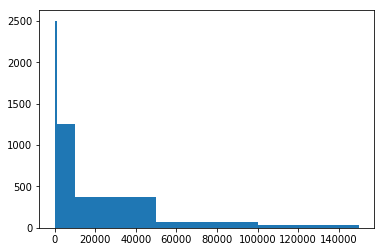

In [45]:
# movie popularity
movie_popularity = df.groupby('movie')['movie'].agg(['count']).reset_index()
plt.hist(movie_popularity['count'],bins=[0,100,1000,10000,50000,100000,150000])

In [46]:
movie_popularity[movie_popularity["count"]<50]

,movie,count
819,820,45
914,915,43
2804,2805,46
3655,3656,42
3692,3693,47
4293,4294,44
4337,4338,39
4361,4362,36


In [198]:
# export to csv
df.to_csv(r'./dataset/formated_1.csv',index=False,sep=',')

In [77]:
# cdf = df.drop([user == ])
# cdf =df.merge(user_activity, left_on='user',right_on='user')
# cdf = cdf[cdf['count']>50][['user','movie','rating']]
print(cdf)
#df.to_csv(r'./dataset/cleaned_1.csv',index=False,sep=',')

             user  movie  rating
0         1488844      1     3.0
1         1488844      8     4.0
2         1488844     17     2.0
3         1488844     30     3.0
4         1488844     44     3.0
5         1488844     58     5.0
6         1488844     76     3.0
7         1488844     80     3.0
8         1488844     81     3.0
9         1488844     83     3.0
10        1488844    108     3.0
11        1488844    111     2.0
12        1488844    118     3.0
13        1488844    143     5.0
14        1488844    173     3.0
15        1488844    175     3.0
16        1488844    187     2.0
17        1488844    189     2.0
18        1488844    191     5.0
19        1488844    195     4.0
20        1488844    197     3.0
21        1488844    199     3.0
22        1488844    216     3.0
23        1488844    232     3.0
24        1488844    241     3.0
25        1488844    268     4.0
26        1488844    270     4.0
27        1488844    273     2.0
28        1488844    275     3.0
29        

In [78]:
test_users = user_activity[user_activity['count']>100].sample(frac=0.1)

In [87]:
train_set = cdf[~(cdf['user'].isin(test_users['user']))]
test_set = cdf[cdf['user'].isin(test_users['user'])]

In [88]:
train_set.to_csv(r'./dataset/cleaned_train_1.csv',index=False,sep=',')
test_set.to_csv(r'./dataset/cleaned_test_1.csv',index=False,sep=',')

In [ ]:
# user 470758, movie 4499
# USER_NUM = 470758
# MOVIE_NUM = 4499

# matrix = []
# for i, user in user_activity.iterrows():
#     movie_list = df[df['user']== user['user']]['movie']
#     rating_list = df[df['user']==user['user']]['rating']
#     ratings = np.zeros(MOVIE_NUM)
#     ratings[movie_list -1] = rating_list
#     matrix.append(list(ratings))

In [349]:
np_matrix = np.array(matrix)

In [352]:
np.savetxt('dataset/np_matrix_1.txt',np_matrix)
# np.loadtxt("np_matrix_1.txt")  

In [342]:
# user 470758, movie 4499
USER_NUM = 5
MOVIE_NUM = 4499
np_matrix = np.zeros((USER_NUM, MOVIE_NUM))
users = list(user_activity['user']) #用户列表
i=0
for user in users:
    user_list = df[df['user']== user] #获取全部用户评分
    np_matrix[i][user_list['movie'] -1] = user_list['rating'] #按index插入评分
    
    i+=1
    if i>USER_NUM-1:
        break

In [58]:
#mg_df = pd.merge(df,user_activity,how='left',on='user')
df = pd.read_csv('./dataset/formated_1.csv', 
                 header = 0, 
                 names = ['user', 'rating','movie'], 
                 usecols = [0,2,1])
df['rating']=df['rating'].astype(float)
df['movie']=df['movie'].astype(float)
df['user']=df['user'].astype(float)

In [72]:
df[['user','movie','rating']]

,user,movie,rating
0,1488844.0,1.0,3.0
1,822109.0,1.0,5.0
2,885013.0,1.0,4.0
3,30878.0,1.0,4.0
4,823519.0,1.0,3.0
5,893988.0,1.0,3.0
6,124105.0,1.0,4.0
7,1248029.0,1.0,3.0
8,1842128.0,1.0,4.0
9,2238063.0,1.0,3.0


In [75]:
sparse_matrix = scipy.sparse.csr_matrix(df[['user','movie','rating']].to_coo())

AttributeError: 'DataFrame' object has no attribute 'to_coo'

In [ ]:
sparse_matrix[:10].toarray()

In [70]:
sparsity = float(len(sparse_matrix.nonzero()[0]))
sparsity /= (sparse_matrix.shape[0] * sparse_matrix.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 100.00%


In [353]:
#RBM

class RBM_basic():
    def __init__(self,  num_visible,num_hidden):
        self.weight = torch.randn(num_hidden,num_visible)
        self.visible_bias = torch.randn(1, num_visible)
        self.hidden_bias = torch.randn(1, num_hidden)
        
    # sample hidden nodes
    def sample_hidden(self, visible_prob):
        weight_visible = torch.mm(visible_prob, self.weight.t())
        h_activation = weight_visible + self.hidden_bias.expand_as(weight_visible)
        prob_h_given_v = torch.sigmoid(h_activation)
        return prob_h_given_v, torch.bernoulli(prob_h_given_v) #prob + 0/1
    
    def sample_visible(self, hidden_prob):
        weight_hidden = torch.mm(hidden_prob, self.weight)
        v_activation = weight_hidden + self.visible_bias.expand_as(weight_hidden)
        prob_v_given_h = torch.sigmoid(v_activation)
        return prob_v_given_h, torch.bernoulli(prob_v_given_h)

    def train(self, visible, k_visible, prob_hidden, k_prob_hidden):
        vh = torch.mm(visible.t(), prob_hidden)
        kvh = torch.mm(k_visible.t(), k_prob_hidden)
        b = vh-kvh
        
        self.weight += b.t()
        self.visible_bias += torch.sum((visible - k_visible), 0)
        self.hidden_bias += torch.sum((prob_hidden - k_prob_hidden), 0)


In [354]:
num_visible = len(matrix[0])
num_hidden = 1
rbm = RBM_basic(num_visible, num_hidden)

In [355]:
#training
training_set = torch.FloatTensor(matrix)
batch_size = 100
nb_epoch = 1
nb_user = len(matrix) - batch_size
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_user, batch_size):
        k_visible = training_set[id_user:id_user+batch_size]
        visible = training_set[id_user:id_user+batch_size]
        prob_hidden,_ = rbm.sample_hidden(visible)
        
        for k in range(10):
            _,k_hidden = rbm.sample_hidden(k_visible)
            _,k_visible = rbm.sample_visible(k_hidden)
            
            k_visible[visible<0] = visible[visible<0]
            
        k_prob_hidden,_ = rbm.sample_hidden(k_visible)
        rbm.train(visible, k_visible, prob_hidden, k_prob_hidden)
        
        train_loss += torch.mean(torch.abs(visible[visible>=0] - k_visible[visible>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(1.00000e-02 *
       8.8429)


In [ ]:
class RBM(torch.nn.Module):
    def __init__(self,  
                 num_visible,
                 num_hidden,
                 lr = 1e-5,
                 k = 10,
                 use_gpu=False
                ):
        super(RBM,self).__init__()
        self.desc = "RBM"
        
        self.weight = torch.randn(num_hidden,num_visible)
        self.visible_bias = torch.randn(1, num_visible)
        self.hidden_bias = torch.randn(1, num_hidden)
        
        self.k = k
        self.use_gpu = use_gpu
        
        
    # sample hidden nodes
    def sample_hidden(self, visible_prob):
        weight_visible = torch.mm(visible_prob, self.weight.t())
        h_activation = weight_visible + self.hidden_bias.expand_as(weight_visible)
        prob_h_given_v = torch.sigmoid(h_activation)
        return prob_h_given_v, torch.bernoulli(prob_h_given_v)
    
    def sample_visible(self, hidden_prob):
        weight_hidden = torch.mm(hidden_prob, self.weight)
        v_activation = weight_hidden + self.visible_bias.expand_as(weight_hidden)
        prob_v_given_h = torch.sigmoid(v_activation)
        return prob_v_given_h, torch.bernoulli(prob_v_given_h)
    
    def contrastive_divergence(self, input_data):
        # Positive phase
        
        # Negative phase
        
        # Update parameters
        
        # Compute reconstruction error
        k_visible = training_set[id_user:id_user+batch_size]
        visible = training_set[id_user:id_user+batch_size]
        prob_hidden,_ = rbm.sample_hidden(visible)
        
        for k in range(10):
            _,k_hidden = rbm.sample_hidden(k_visible)
            _,k_visible = rbm.sample_visible(k_hidden)
            k_visible[visible<0] = visible[visible<0]
            
        k_prob_hidden,_ = rbm.sample_hidden(k_visible)
        rbm.train(visible, k_visible, prob_hidden, k_prob_hidden)   
        pass

    def train(self, input_data):
        batch_size = input_data.size(0)
        # positive CD phase
        
        
        # negative CD phase,k-step
        for k in range(self.k):
            _,k_hidden = self.sample_hidden(k_visible)
            _,k_visible = self.sample_visible(k_hidden)
            k_visible[visible<0] = visible[visible<0]
        k_prob_hidden,_ = rbm.sample_hidden(k_visible)
        rbm.train(visible, k_visible, prob_hidden, k_prob_hidden)
        
        vh = torch.mm(visible.t(), prob_hidden)
        kvh = torch.mm(k_visible.t(), k_prob_hidden)
        b = vh-kvh
        self.weight += b.t()
        self.visible_bias += torch.sum((visible - k_visible), dim=0)
        self.hidden_bias += torch.sum((prob_hidden - k_prob_hidden), dim=0)
        
        
        
    def forward(input_data):
        return self.sample_hidden(input_data)


In [ ]:
# save model
torch.save(RBM,'mymodel.pkl')

# load model
RBM =torch.load('mymodel.pkl')